<a href="https://colab.research.google.com/github/SamEhrlich/bat_speed/blob/main/bat_speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:  
[bat speed equation](http://tangotiger.com/index.php/site/article/statcast-lab-collisions-and-the-perfect-swing)  from Tom Tango and Alan Nathan  
[Fangraph's squared up rate article](https://blogs.fangraphs.com/squared-up-rate-and-launch-angle-a-visual-investigation/)  by Ben Clemens  
[Statcast Bat Tracking](https://baseballsavant.mlb.com/leaderboard/bat-tracking)  
[bat speed discussion](https://twitter.com/matan_writes/status/1790455989017137333) by Matan K  
[bat speed stream](https://www.twitch.tv/nickwan_datasci/video/2151051490) by Red's analyst Nick Wan on Twitch   
[Lahman People database](https://github.com/jldbc/pybaseball/issues/391) issues pulling through pybaseball  
[MLB Stats API](https://github.com/toddrob99/MLB-StatsAPI) wrapper by Todd Roberts to pull player height and weight from their bios


In [1]:
!pip install pybaseball
!pip install MLB-StatsAPI
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pybaseball as pbb
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import math
import statsapi
import optuna
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [3]:
#faster loading
# project_dir = 'drive/My Drive/Colab Notebooks/projects24'
# year = 2024
# df = pd.DataFrame()
# df = pd.read_csv("{}/{}-data.csv".format(project_dir,year))

#loading with height and weight
# project_dir = 'drive/My Drive/Colab Notebooks/projects24'
# year = 2024
# df = pd.DataFrame()
# df = pd.read_csv("{}/{}-fe-data.csv".format(project_dir,year))


In [5]:
# download 2024 data
project_dir = 'drive/My Drive/Colab Notebooks/projects24'
df = pd.DataFrame()
year = 2024

df = pbb.statcast(start_dt="{}-03-01".format(year), end_dt="{}-12-01".format(year))
df.to_csv("{}/{}-data.csv".format(project_dir,year), index=False)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [02:10<00:00,  1.88it/s]


In [6]:
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
650,SL,2024-07-01,83.0,-2.68,5.71,"Payamps, Joel",595909,606303,single,hit_into_play,...,8,8,7,Strategic,Strategic,50,0.171,1.235,69.313501,7.17698
673,FF,2024-07-01,94.4,-2.44,5.52,"Payamps, Joel",669911,606303,field_out,hit_into_play,...,7,7,7,Standard,Standard,228,0.023,-0.414,72.075017,7.37408
725,FF,2024-07-01,94.8,-2.51,5.55,"Payamps, Joel",669911,606303,NaN,foul,...,7,7,7,Standard,Standard,222,0.0,0.0,72.484653,7.05842
737,SL,2024-07-01,81.9,-2.73,5.76,"Payamps, Joel",669911,606303,NaN,swinging_strike,...,7,7,7,Standard,Standard,50,0.0,-0.147,73.337257,9.14219
765,SL,2024-07-01,81.9,-2.72,5.68,"Payamps, Joel",669911,606303,NaN,ball,...,7,7,7,Standard,Standard,55,0.0,0.136,<NA>,<NA>


In [7]:
df.shape

(403285, 94)

In [8]:
df.columns.values

array(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4',
       'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'release_pos_y', 'estima

In [9]:
#learn more about the new columns
df[['bat_speed','swing_length']].describe()

,bat_speed,swing_length
count,156237.0,156223.0
mean,69.525722,7.227986
std,8.583217,0.979222
min,0.851208,0.30587
25%,67.006567,6.66037
50%,70.908361,7.28141
75%,74.196194,7.88368
max,87.978801,10.38686


In [10]:
#create new columns that will help analyze the new features

#id swinging events
df['swing'] = 0
df.loc[df['description'].isin(['foul','strike_swinging','hit_into_play','foul_tip','swinging_strike_blocked']), 'swing'] = 1

#define a whiff
df['whiff'] = 0
df.loc[(df['swing'] == 1) & (df['description'].isin(['strike_swinging','swinging_strike_blocked','foul_tip'])), 'whiff'] = 1

#define contact swings
df['contact'] = 0
df.loc[df['description'].isin(['foul','hit_into_play','foul_tip']), 'contact'] = 1

#id hit events
df['hit'] = 0
df.loc[df['events'].isin(['single','double','triple','home_run']), 'hit'] = 1

#id home team team
df['p_team'] = df['away_team']
df.loc[(df['inning_topbot'] == 'Top'), 'p_team'] = df.loc[(df['inning_topbot'] == 'Top'), 'home_team']

#create attack zones
df['attack_zone'] = 'waste'
df.loc[(df['plate_x'].between(-0.558, 0.558)) & (df['plate_z'].between(1.833,3.166)), 'attack_zone'] = 'heart'
df.loc[(df['plate_x'].between(-1.108, 1.108)) & (df['plate_z'].between(1.166,3.833)) & (~df['attack_zone'].isin(['heart'])), 'attack_zone'] = 'shadow'
df.loc[(df['plate_x'].between(-1.666, 1.666)) & (df['plate_z'].between(0.5,4.5)) & (~df['attack_zone'].isin(['heart', 'shadow'])), 'attack_zone'] = 'chase'

#mark handedness of batter and pitcher
df['is_lhb'] = 0
df.loc[df['stand'] == 'L', 'is_lhb'] = 1
df['is_lhp'] = 0
df.loc[df['p_throws'] == 'L', 'is_lhp'] = 1

#create spray angle
df['spray_angle'] = 0
df['spray_angle'] = round(np.arctan((df['hc_x'] - 125.42) / (198.27 - df['hc_y'])) * 180 / math.pi * 0.75, 1)

#get batter names using chadwick ids in pybaseball
df = df.rename(columns={'player_name':'pitcher_name'})
batter_bio = pbb.playerid_reverse_lookup(df['batter'].unique().tolist())
batter_bio['batter_name'] = batter_bio['name_last'].add(', ').add(batter_bio['name_first'])
df = df.merge(batter_bio.loc[:, ['key_mlbam','batter_name']].rename(columns={'key_mlbam':'batter'}), how='left')
df = df.rename(columns={'player_name':'pitcher_name'})



Gathering player lookup table. This may take a moment.


In [11]:
#bat tracking is not fully complete - looks like start is 4/03
df[['game_date','bat_speed','swing_length']].loc[~(df['bat_speed'].isna()) & ~(df['swing_length'].isna())].sort_values('game_date')

,game_date,bat_speed,swing_length
343497,2024-04-03,81.28998,8.64742
340989,2024-04-03,67.099442,5.91682
340990,2024-04-03,74.167446,7.6177
340991,2024-04-03,71.077564,6.34732
340992,2024-04-03,63.93202,5.74847
...,...,...,...
602,2024-07-01,63.152123,6.30539
603,2024-07-01,60.23812,5.06741
605,2024-07-01,70.665413,8.33233
586,2024-07-01,70.717082,6.18284


In [12]:
#filter df to have complete values
df = df.dropna(subset = ['bat_speed','swing_length'])

In [13]:
#define competitive swings - top 90% of batter's swings along with any swing with bat speed >= 60mph and ev >= 90mph
b10 = df[['batter','bat_speed']].groupby('batter').quantile(0.1).reset_index().rename(columns = {'bat_speed':'bottom_10_swings'})
df = df.merge(b10, how = 'left', on = 'batter')
df['competitive_swing'] = 0
df.loc[(df['bat_speed'] >= df['bottom_10_swings']) | ((df['bat_speed'] >= 60) & (df['launch_speed'] >= 90)), 'competitive_swing'] = 1
print('number of swings removed: ', len(df[['bat_speed','bottom_10_swings','launch_speed','competitive_swing']].loc[(df['competitive_swing'] == 0)]))

#remove non competitive swings for rest of project
df = df.loc[df['competitive_swing'] == 1]

number of swings removed:  15208


In [14]:
#creating squared up rates - anything above 80% of max exit velo based on pitch type and swing
q = 0.23
df['max_ev'] = df['bat_speed'].mul(1+q).add(df['release_speed'].mul(.92).mul(q))
df['squared_up_pct'] = df['launch_speed'].div(df['max_ev'])
df['squared_up'] = 0
df.loc[df['squared_up_pct'] > 0.8, 'squared_up'] = 1

df[['batter_name','bat_speed','launch_speed','max_ev','squared_up_pct']].sort_values('squared_up_pct', ascending=False).head(10)

,batter_name,bat_speed,launch_speed,max_ev,squared_up_pct
27668,"robert, luis",60.739159,109.1,93.351126,1.168706
143408,"montero, elehuris",62.319919,107.9,93.623821,1.152484
27088,"chapman, matt",62.474018,107.6,95.125282,1.13114
4991,"tellez, rowdy",60.002664,102.9,91.006357,1.13069
81283,"rooker, brent",61.309552,106.3,94.835629,1.120887
133158,"hernández, teoscar",60.842108,106.5,95.043592,1.120538
147852,"meneses, joey",61.00963,102.0,91.652445,1.1129
100508,"albies, ozzie",61.693918,106.2,95.625799,1.110579
22744,"rojas, miguel",66.168019,109.8,98.928304,1.109895
127329,"stott, bryson",62.017136,103.3,93.738078,1.102007


In [15]:
#define fast swings and fast swing rates - any swings that reach 75mph
df['fast_swing'] = 0
df.loc[(df['bat_speed'] >= 75), 'fast_swing'] = 1

#get a count of fast swings - dropped from 23% earlier in season to 19%
print('fast swing pct:', len(df.loc[(df['bat_speed'] >= 75)]) / len(df) * 100)

swing_cnt = df[['batter','bat_speed']].groupby('batter').count().reset_index().rename(columns={'bat_speed':'swing_count'})
fast_swing_cnt = df[['batter','fast_swing']].groupby('batter').sum().reset_index().rename(columns={'fast_swing':'fast_swing_count'})
swing_cnt = swing_cnt.merge(fast_swing_cnt, how = 'left', on = 'batter')
swing_cnt['fast_swing_rate'] = swing_cnt['fast_swing_count']/swing_cnt['swing_count']
#get the highest fast swing rated players
batter_names_list = df[['batter','batter_name']].drop_duplicates()
batter_swings = swing_cnt.merge(batter_names_list, how = 'left', on = 'batter')
batter_swings[['batter_name','swing_count','fast_swing_rate']].sort_values(by = 'fast_swing_rate', ascending = False).reset_index().head(10)

fast swing pct: 21.98134950182605


,index,batter_name,swing_count,fast_swing_rate
0,356,"mitchell, garrett",3,1.000000
1,20,"stanton, giancarlo",423,0.983452
2,394,"wallner, matt",32,0.906250
3,302,"camargo, jair",7,0.857143
4,420,"canario, alexander",36,0.805556
5,551,NaN,5,0.800000
6,463,"noel, jhonkensy",29,0.793103
7,451,"tena, josé",4,0.750000
8,225,"schwarber, kyle",467,0.749465
9,300,"cruz, oneil",397,0.748111


In [16]:
#avg bat speed for competitive swings
avg_bat_speed_df = df[['batter','bat_speed']].groupby('batter').mean().sort_values(by = 'bat_speed', ascending = False).reset_index()
avg_bat_speed_df = avg_bat_speed_df.merge(batter_names_list, how = 'left', on = 'batter')
avg_bat_speed_df[['batter_name','bat_speed']].head(10)

,batter_name,bat_speed
0,"stanton, giancarlo",80.754889
1,"noel, jhonkensy",78.497221
2,"wallner, matt",78.40947
3,"cruz, oneil",78.133208
4,"camargo, jair",77.776482
5,"canario, alexander",77.565382
6,"mitchell, garrett",77.509807
7,"schwarber, kyle",77.145802
8,"tena, josé",77.095453
9,"chapman, matt",76.9188


In [29]:
#use mlb stats api to pull height and weight of each player

#create lists to store player info
player_ids = batter_bio['key_mlbam']
height = []
weight = []

#create a log to follow in loop progress
log_batter = 100

#loop through the ids and make an api call to get the players raw states json
for batter in range(len(player_ids)):
  player_bio = statsapi.get('people', {'personIds':player_ids[batter]}, force=False)
  # print('grabbing {} height and weight'.format(player_ids[batter]))
  #grab weight and height info from the json file
  _weight = player_bio['people'][0]['weight']
  _height_raw = player_bio['people'][0]['height']
  _height_ft = int(_height_raw.split('\' ')[0])
  _height_in = int(_height_raw.split('\' ')[1].replace('"', ''))
  _height = _height_ft*12 + _height_in
  # print('height ft: ', _height_ft, 'height in: ', _height_in, 'weight: ', _weight)
  # print(_height)
  #append the height and weight to the player
  height.append(_height)
  weight.append(_weight)
  if (batter % log_batter) == 0:
    print( batter, 'batters completed')


#join the height and weight columns to the dataframe
batter_bio['height'] = height
batter_bio['weight'] = weight
df = df.merge(batter_bio.loc[:, ['key_mlbam','height','weight']].rename(columns={'key_mlbam':'batter'}), how='left')

# save df with height and weight to save time
# df.to_csv("{}/{}-fe-data.csv".format(project_dir,year), index = False)


0 batters completed
100 batters completed
200 batters completed
300 batters completed
400 batters completed
500 batters completed
600 batters completed


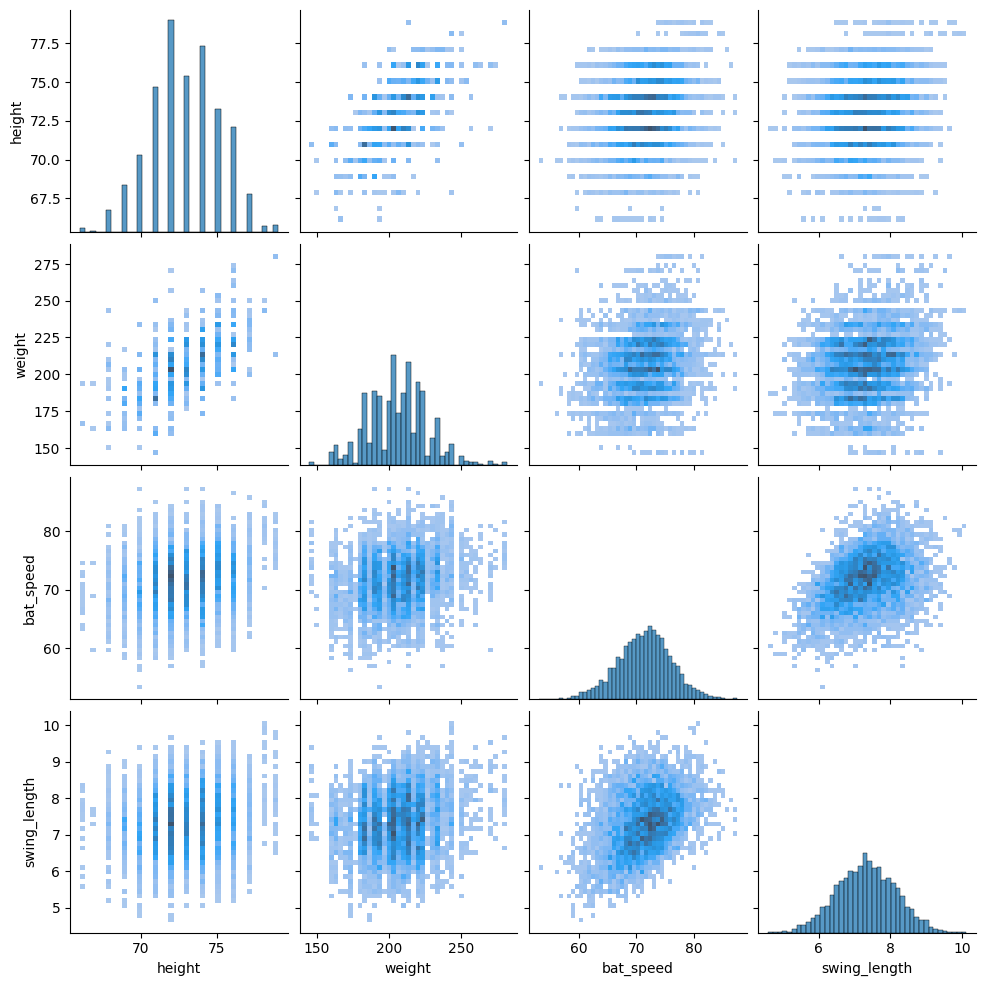

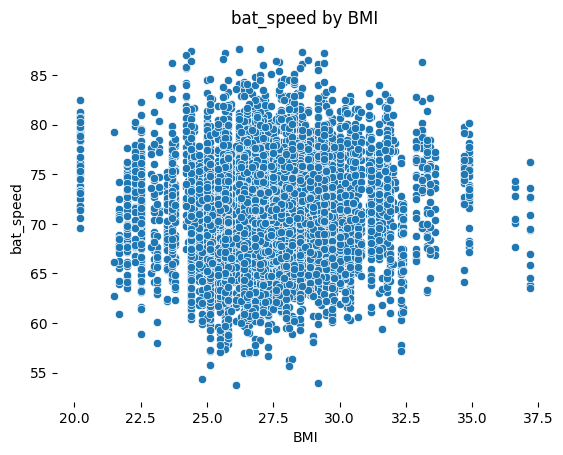

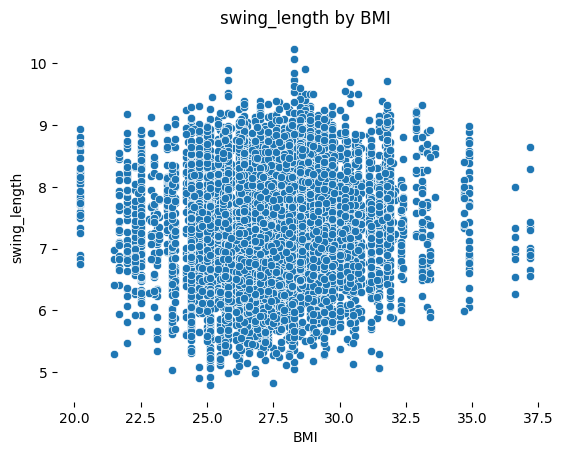

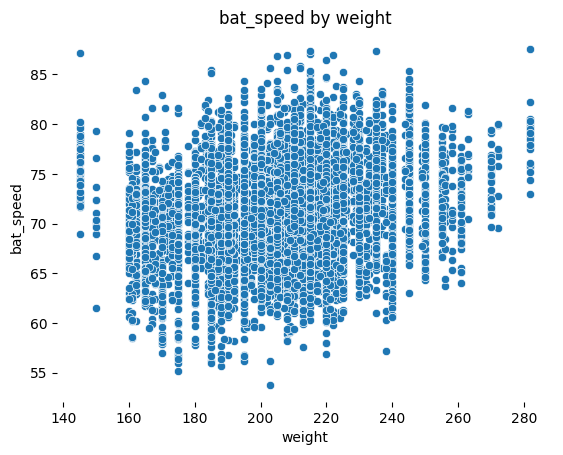

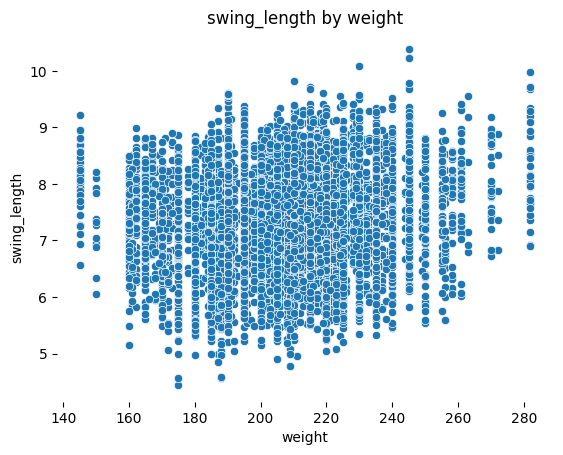

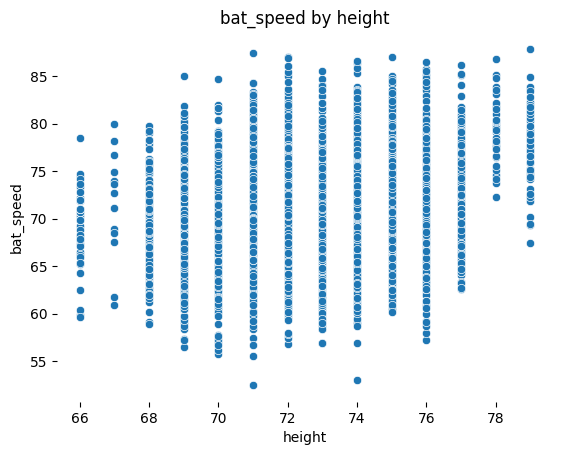

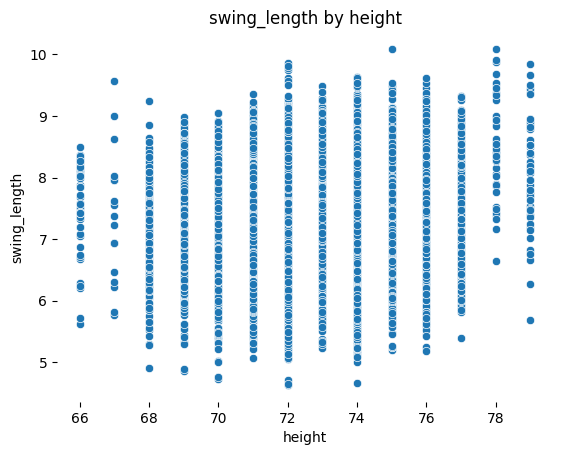

In [43]:
#view correlation between height/weight and bat speed/swing length

#pairplot to view correlations
sns.pairplot(df.loc[:, ['height','weight','bat_speed','swing_length']].sample(5000), kind="hist")
plt.show()

#create BMI to get a similar interaction using both weight and height in 1 feature (weight / lbs) * 703
df['BMI'] = round(df['weight'].div(df['height']).div(df['height']).mul(703),1)

#regression plot BMI x bat speed
for x in ['BMI','weight','height']:
  for y in ['bat_speed','swing_length']:
    sns.scatterplot(data=df.sample(10000), x=x, y=y)
    plt.title('{} by {}'.format(y,x))
    plt.xlabel(x)
    plt.ylabel(y)
    sns.despine(left = True, bottom = True)
    plt.show()

#slight positive correlation between size and speed



<ipython-input-44-360854370e7e>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(y * 100) for y in  plt.gca().get_yticks()]) #changes density from 0-1 scale to percentage


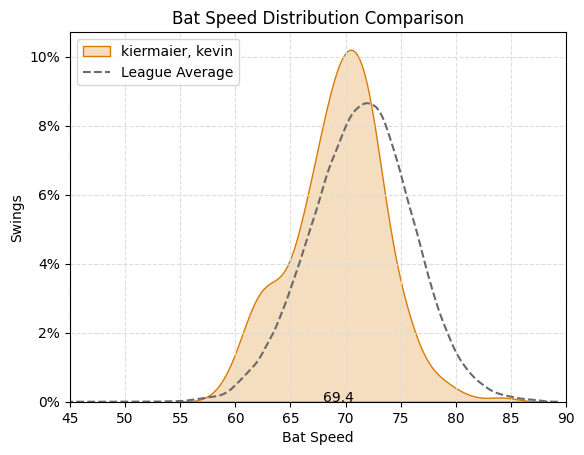

In [44]:
#bat speed comparison plot from statcast

def plot_bat_speed_distribution(df = df, batter_id = 621020):
  batter_name = df['batter_name'].loc[df['batter'] == batter_id].to_list()[0]
  sns.kdeplot(df.loc[df['batter'] == batter_id], x = 'bat_speed', fill=True, color = '#D87B05', label = batter_name)
  plt.text(df['bat_speed'].loc[df['batter'] == batter_id].mean(), s = round(df['bat_speed'].loc[df['batter'] == batter_id].mean(),1), y = 0, ha = 'center')
  sns.kdeplot(df, x = 'bat_speed', c = '#696968', ls = '--', label = 'League Average')
  plt.xlabel('Bat Speed')
  plt.ylabel('Swings')
  plt.title('Bat Speed Distribution Comparison')
  plt.legend(bbox_to_anchor=(0,1), loc = 2)
  plt.xlim(45,90)
  plt.grid(color = '#DDDDDD', ls = '--')
  plt.gca().set_yticklabels(['{:.0f}%'.format(y * 100) for y in  plt.gca().get_yticks()]) #changes density from 0-1 scale to percentage
  plt.show()



plot_bat_speed_distribution(batter_id= 595281)

count    561.000000
mean     200.221034
std      140.771703
min        0.000000
25%       70.000000
50%      186.000000
75%      314.000000
max      508.000000
Name: swing_cnt, dtype: float64


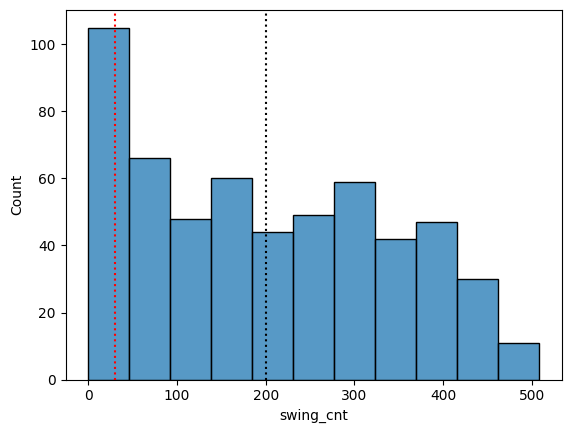

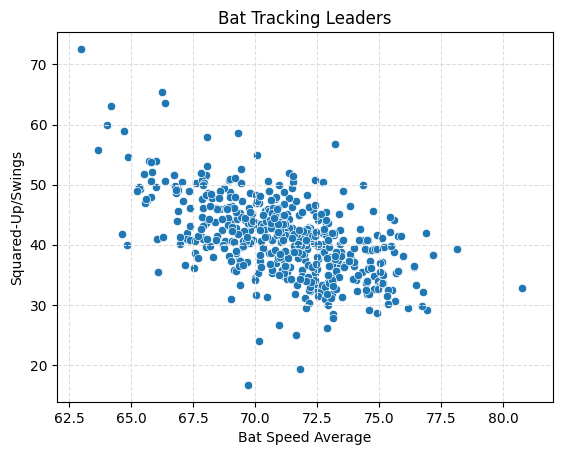

In [45]:
#squared up / swing vs avg bat speed plot

#get the aggregates and join
bat_speed_summary = df.loc[:,['batter','bat_speed']].groupby('batter').mean().rename(columns={'bat_speed':'avg_bat_speed'}).reset_index()
swing_squared_up = df.loc[:,['batter','swing','squared_up']].groupby('batter').sum().reset_index().rename(columns = {'swing':'swing_cnt','squared_up':'squared_up_cnt'})

bat_speed_summary = bat_speed_summary.merge(swing_squared_up, how = 'left', on = 'batter')
bat_speed_summary['swing_squared_up_pct'] = bat_speed_summary['squared_up_cnt']/bat_speed_summary['swing_cnt']*100

#learn about swing count
print(bat_speed_summary['swing_cnt'].describe())

#visualize the distribution of competitive swings
sns.histplot(bat_speed_summary, x = 'swing_cnt')
plt.axvline(bat_speed_summary['swing_cnt'].mean(), color = 'black', ls = ':')
plt.axvline(30, color = 'red', ls = ':')
plt.show()

#minimum 30 swings to qualify for plot - better if interactive with plotly
sns.scatterplot(data = bat_speed_summary.loc[bat_speed_summary['swing_cnt'] >= 30], x = 'avg_bat_speed', y = 'swing_squared_up_pct')
plt.xlim(62,82)
plt.xlabel('Bat Speed Average')
plt.ylabel('Squared-Up/Swings')
plt.title('Bat Tracking Leaders')
plt.grid(color = '#DDDDDD', ls = '--')
plt.show()


In [46]:
#feature engineer vertical approach angle and horizontal approach angle
#vaa
df['vy_f'] = -np.sqrt(df['vy0']**2 - 2 * df['ay'] * (50 - 17/12))
df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
df['vaa'] = -np.arctan(df['vz_f']/df['vy_f']) * (180 / np.pi)
#haa
df['vy_f'] = -np.sqrt(df['vy0']**2 - 2 * df['ay'] * (50 - 17/12))
df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])
df['haa'] = -np.arctan(df['vx_f']/df['vy_f']) * (180 / np.pi)
#drop columns
df = df.drop(['vy_f','t','vz_f','vx_f'], axis = 1)

In [47]:
#build optimization function defining the objective

#define features and target
descriptive_feats = ['batter','batter_name','game_year']
model_feats = ['bat_speed','swing_length','height','weight','vaa','haa','is_lhb','is_lhp']
target = ['delta_run_exp']

#create model dataframe
model_df = df[descriptive_feats + model_feats + target].dropna().reset_index()

X = model_df[model_feats]
y = model_df[target]


#define objective function
def objective(trial, X = X, y = y):

    #split data using train and test split from sklearn 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

    #define parameters to test
    param = {
        # 'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        # 'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.03,0.1,0.15,0.2, 0.3]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [3,5,7,9,11,13]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'early_stopping_rounds' : 100
    }

    #set model with parameter search space
    model = xgb.XGBRegressor(**param)

    #fit the model
    model.fit(X_train, y_train, eval_set=[(X_test,y_test)],verbose=False)

    #make predictions
    preds = model.predict(X_test)

    #evalutate the model based on mean squared error
    mse = mean_squared_error(y_test, preds, squared=False)

    return mse

In [48]:
#build out the optuna parameter search study
study = optuna.create_study(direction='minimize') #objective is to minimize the mean squared error
study.optimize(objective, n_trials = 30) #30 trails to be completed
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-07-02 19:37:06,334] A new study created in memory with name: no-name-dfff8f4b-f7aa-4fae-95aa-32df3df6966e
[I 2024-07-02 19:37:07,421] Trial 0 finished with value: 0.3398239170162463 and parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.15, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 283}. Best is trial 0 with value: 0.3398239170162463.
[I 2024-07-02 19:37:11,116] Trial 1 finished with value: 0.339340731128817 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 107}. Best is trial 1 with value: 0.339340731128817.
[I 2024-07-02 19:37:12,891] Trial 2 finished with value: 0.33934209776576957 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 1 with value: 0.339340731128817.
[I 2024-07-02 19:37:15,570] Trial 3 finished with value: 0.3395138435694221 and parameters: {'colsample_bytree': 0.4, 'learning_ra

Number of finished trials: 30
Best trial: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 241}


In [49]:
#visualize how the study went
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,state
0,0,0.339824,2024-07-02 19:37:06.336192,2024-07-02 19:37:07.420696,0 days 00:00:01.084504,0.6,0.15,11,283,2020,COMPLETE
1,1,0.339341,2024-07-02 19:37:07.423240,2024-07-02 19:37:11.116543,0 days 00:00:03.693303,0.7,0.01,5,107,2020,COMPLETE
2,2,0.339342,2024-07-02 19:37:11.118880,2024-07-02 19:37:12.890771,0 days 00:00:01.771891,0.7,0.10,3,10,2020,COMPLETE
3,3,0.339514,2024-07-02 19:37:12.893269,2024-07-02 19:37:15.570066,0 days 00:00:02.676797,0.4,0.20,5,108,2020,COMPLETE
4,4,0.339543,2024-07-02 19:37:15.575235,2024-07-02 19:37:16.630622,0 days 00:00:01.055387,0.9,0.30,9,300,2020,COMPLETE
5,5,0.339811,2024-07-02 19:37:16.635723,2024-07-02 19:37:17.706775,0 days 00:00:01.071052,0.8,0.15,11,167,2020,COMPLETE
6,6,0.340309,2024-07-02 19:37:17.711005,2024-07-02 19:37:19.550450,0 days 00:00:01.839445,0.3,0.03,13,11,2020,COMPLETE
7,7,0.339824,2024-07-02 19:37:19.554543,2024-07-02 19:37:20.487108,0 days 00:00:00.932565,0.7,0.15,11,121,2020,COMPLETE
8,8,0.339651,2024-07-02 19:37:20.491144,2024-07-02 19:37:21.257573,0 days 00:00:00.766429,0.5,0.20,7,280,2020,COMPLETE
9,9,0.340727,2024-07-02 19:37:21.261691,2024-07-02 19:37:23.812282,0 days 00:00:02.550591,0.7,0.15,13,1,2020,COMPLETE


In [50]:
#visualize the progression of the study
optuna.visualization.plot_optimization_history(study)

In [51]:
#view how each feature was progressing
optuna.visualization.plot_slice(study)

In [52]:
#visualize parameter importance plot
optuna.visualization.plot_param_importances(study)

In [53]:
#define the best trail to use for the model building phase
best_trial = study.best_trial.params
best_trial

{'colsample_bytree': 0.8,
 'learning_rate': 0.03,
 'max_depth': 3,
 'random_state': 2020,
 'min_child_weight': 241}

In [54]:
#swing model

descriptive_feats = ['batter','batter_name','game_year']
model_feats = ['bat_speed','swing_length','height','weight','vaa','haa','is_lhb','is_lhp']
target = ['delta_run_exp']

#create model dataframe
model_df = df[descriptive_feats + model_feats + target].dropna().reset_index()

#use kfold just like with ssw to utilize all data in train and test sets
folds = 3
kf = KFold(folds, shuffle=True)

#create a series to store index and model predictions
xrv_output = pd.Series()

#create a dataframe to store feature importance of each model
var_imp_df = pd.DataFrame()

#within each family split and run xgboost across all 3 folds
for train_idx, test_idx in kf.split(model_df):
  train = model_df.iloc[train_idx] #split by train index
  test = model_df.iloc[test_idx] #split by test index

  #run xgb model
  model = xgb.XGBRegressor(**best_trial) #initialize model with the best fit hyperparameters
  model.fit(train.loc[:, model_feats], train[target]) #fit training data

  #get base xgb feature importance from model
  feature_important = model.get_booster().get_score(importance_type='weight')
  keys = list(feature_important.keys())
  values = list(feature_important.values())
  _var_imp_df = pd.DataFrame(data=values, columns=['score'])
  _var_imp_df['feature'] = keys
  var_imp_df = pd.concat([var_imp_df, _var_imp_df])

  preds = model.predict(test.loc[:, model_feats]) #predict on test data
  idx = test.index #save index of test data to return back to original df
  model_series = pd.Series(preds, index=idx) #store predictions and index
  xrv_output = pd.concat([xrv_output, model_series]) #join predictions and index into series made out of loop to store all outputs


model_df['xrv'] = xrv_output



In [55]:
model_df.head()

,index,batter,batter_name,game_year,bat_speed,swing_length,height,weight,vaa,haa,is_lhb,is_lhp,delta_run_exp,xrv
0,0,595909,"cave, jake",2024,69.313501,7.17698,72.0,200.0,-7.707033,3.792246,1,0,1.235,-0.019485
1,1,669911,"toglia, michael",2024,72.075017,7.37408,77.0,226.0,-5.688318,2.419477,1,0,-0.414,-0.002459
2,2,669911,"toglia, michael",2024,72.484653,7.05842,77.0,226.0,-5.131064,2.677974,1,0,0.0,-0.002459
3,3,669911,"toglia, michael",2024,73.337257,9.14219,77.0,226.0,-7.680502,4.054135,1,0,-0.147,-0.068804
4,4,669911,"toglia, michael",2024,73.720464,6.91968,77.0,226.0,-3.981018,2.200061,1,0,-0.054,-0.024723


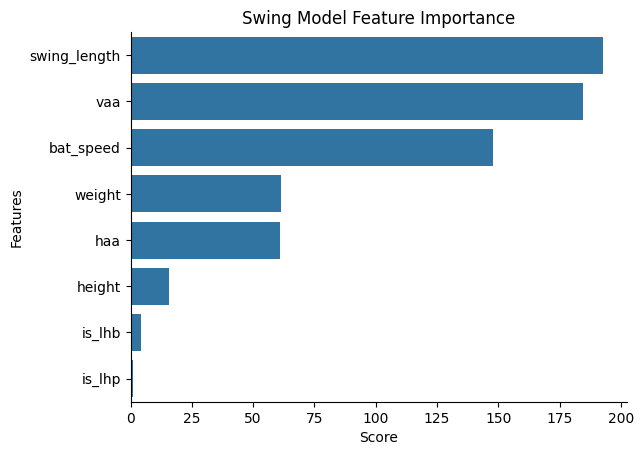

In [56]:
var_imp_summary_df = var_imp_df.groupby(['feature']).mean().reset_index().sort_values(by = 'score', ascending = False)

sns.barplot(data = var_imp_summary_df, x = 'score', y = 'feature')
sns.despine()
plt.title('Swing Model Feature Importance')
plt.xlabel('Score')
plt.ylabel('Features')
plt.show()


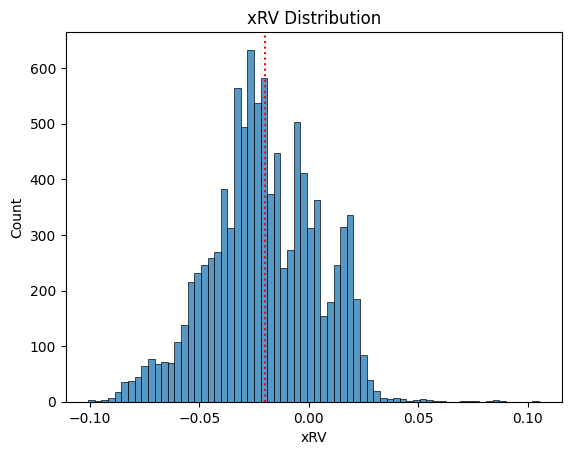

             xrv
count  141008.00
mean       -0.02
std         0.02
min        -0.10
25%        -0.04
50%        -0.02
75%        -0.00
max         0.11


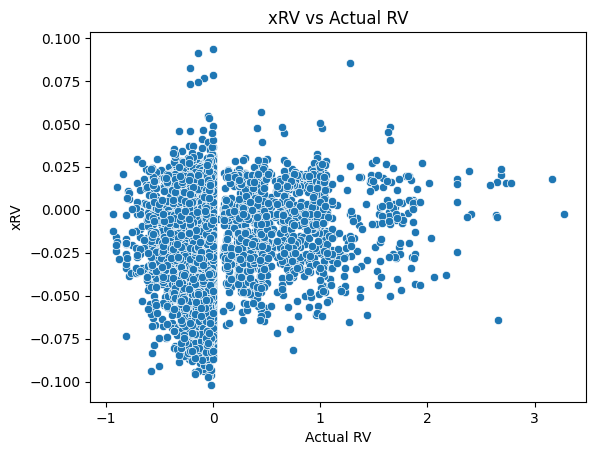

In [57]:
#distribution of xrv
sns.histplot(model_df['xrv'].sample(10000))
plt.title('xRV Distribution')
plt.xlabel('xRV')
plt.ylabel('Count')
plt.axvline(model_df['xrv'].mean(),  c='r', ls = ':')
plt.show()

#info about xrv column
print(model_df[['xrv']].describe().applymap(lambda x: f"{x:0.2f}"))

#actual vs expected run value plot
sns.scatterplot(model_df.sample(10000), x = 'delta_run_exp', y = 'xrv')
plt.title('xRV vs Actual RV')
plt.xlabel('Actual RV')
plt.ylabel('xRV')
plt.show()

In [58]:
#which players return the highest xRV based off swing model?

swing_model_summary = model_df.loc[:,['batter','xrv']].groupby('batter').sum().reset_index()
swing_count = model_df.loc[:,['batter','xrv']].groupby('batter').count().reset_index().rename(columns = {'xrv':'swing_cnt'})
swing_model_summary = swing_model_summary.merge(swing_count, how = 'left', on = 'batter')
swing_model_summary = swing_model_summary.merge(batter_names_list, how = 'left', on = 'batter')
swing_model_summary[['batter','batter_name','swing_cnt','xrv']].sort_values(by = 'xrv', ascending = False).head(10)

,batter,batter_name,swing_cnt,xrv
69,592450,"judge, aaron",512,13.808919
20,519317,"stanton, giancarlo",423,1.845596
451,677588,"tena, josé",4,0.070041
340,668723,"vilade, ryan",11,0.026419
356,669003,"mitchell, garrett",3,0.015892
473,680716,"ornelas, jonathan",1,0.014328
394,670242,"wallner, matt",32,0.012393
176,642215,"wilson, weston",1,0.003378
88,596115,"story, trevor",7,-0.002620
433,676070,"amaya, jacob",1,-0.019263


In [59]:
#grab top 5 batters from the model and investigate more
top5 = swing_model_summary[['batter','batter_name','xrv']].sort_values(by = 'xrv', ascending = False).head(5)
top5_batterid = top5['batter'].tolist()
#filter for data on the top 5 batters
top5_df = model_df.loc[model_df['batter'].isin(top5_batterid)]

In [60]:
#check the top xRV batters in the model to see if they have a similar swing length or bat speed

top5_avgs = top5_df[['batter','bat_speed','swing_length']].groupby('batter').mean().reset_index().rename(columns = {'bat_speed':'avg_bat_speed','swing_length':'avg_swing_length'})
top5.merge(top5_avgs, how = 'left', on = 'batter')

,batter,batter_name,xrv,avg_bat_speed,avg_swing_length
0,592450,"judge, aaron",13.808919,76.890148,8.18695
1,519317,"stanton, giancarlo",1.845596,80.754889,8.399715
2,677588,"tena, josé",0.070041,77.095453,7.590687
3,668723,"vilade, ryan",0.026419,76.699146,7.516928
4,669003,"mitchell, garrett",0.015892,77.509807,7.3369


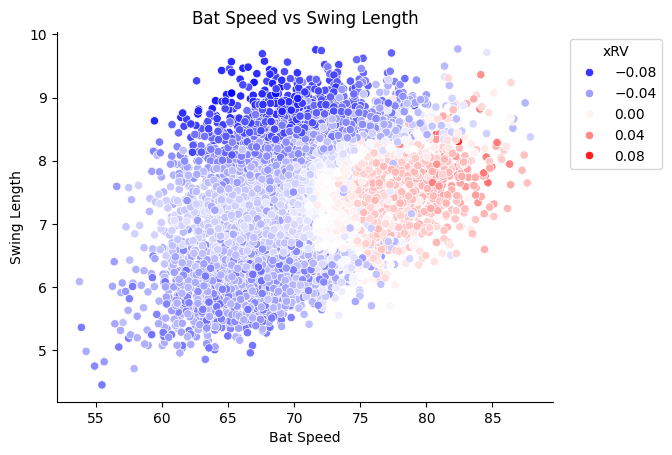

In [61]:
sns.scatterplot(model_df.sample(10000), x = 'bat_speed', y= 'swing_length', hue = 'xrv', palette = 'bwr')
plt.legend(bbox_to_anchor=(1.02, 1), loc = 2, title = 'xRV')
plt.title('Bat Speed vs Swing Length')
plt.xlabel('Bat Speed')
plt.ylabel('Swing Length')
sns.despine()
plt.show()

This project was to investigate the new swing length and bat speed features that have been added to the statcast dataset. I believe that these new features are useful for understanding the differences between batters at a per swing basis. Although these features are still new, they may be able to give more context about a batter than features that have been used in the past like exit velocity and launch angle. Launch angle and exit velocity rely on contact to provide context about the swing, but bat speed and swing length can be tracked without any contact being necessary. Even more could be discovered if these new features are collected each year and found to have a sticky year to year correlation.

If additional features like these are released in the future, I could see a major shift in player development along with a deeper understanding of batting as a whole. Similar to pitching models are set to evalute each pitch that is thrown, I think competitive swings could be awarded a value that is equivalent to Stuff for the batting side based on the quality of the swing. Swinging a bat is one of the most valued parts of baseball, because the goal of the game is to put runs on the board. Although you could technically win without hitting a ball, it would be much easier to win by hitting the ball with good swings of the bat.

There are different features that I believe could be useful for putting value on a swing. Some of this data is accessible or easy to create through feature engineering, but other data is not currently available to the public.

Features currently available:
1.  plate location
  - where the ball crosses the plate
2. approach angles
  - how the ball is angled when it reaches the tip of home plate
3. context of the swing
  - bat speed, swing length
4. context of the game
  - balls, strikes, outs, runners on base, pitch count, score of game all provide insight into the context of the swing
5. size of the player
  - height and weight can indicate how much power a player can create

Features not currently available:
1. location in the box
  - a batter can stand anywhere in the box when they take an AB. Knowning where they are standing can help proivde knowledge about how the batter is taking their approach.
2. stance size
  - a batter can generate a lot of their power through their stance. Paired with where they stand, this kind of information can provide a lot for a batting model.
3. hand location or swing starting position
  - Batters can choke up on the bat to catch pitches thrown inside and adjust their swing based on a the types of pitches they are facing
4. swing angle
  - A flatter swing that stays in the zone longer has more time to make contact. There have also been studies about swinging down or up on a ball. These studies were made with launch angle data that showed the best results when a batter makes contact. Swing angle could make for a more reliable swing without the need to make contact.

  The current model clearly favors bat speeds of around 80mph and a swing length between 7-8.5in. Any swing with a longer length than 7, but a slower bat speed tends to do the worst with the model. This finding is worth nothing, because a slow bat with a long path is usually late to make contact if making any contact at all. A faster bat will provide more power and arrive on time to make contact. With additional features I think the model could start to be useful, but as the model stands it is too inconsistant.